In [2]:
import cv2
import imutils
from skimage.filters import threshold_local
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image


In [3]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [4]:
def gaussian_kernel(size, sigma=1):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel / (2 * np.pi * sigma ** 2)

def gaussian_blur(image, size=5, sigma=1.4):
    kernel = gaussian_kernel(size, sigma)
    filtered_image = np.zeros_like(image)
    image_padded = np.pad(image, ((size//2, size//2), (size//2, size//2)), mode='constant')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            filtered_image[i, j] = np.sum(kernel * image_padded[i:i+size, j:j+size])
    return filtered_image

In [5]:
def sobel_filter(img, axis):
    if axis == 'x':
        kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    elif axis == 'y':
        kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    else:
        raise ValueError("Invalid axis parameter. Must be 'x' or 'y'.")

    padded_img = np.pad(img, 1, mode='edge')
    output = np.zeros_like(img)

    for i in range(1, img.shape[0] + 1):
        for j in range(1, img.shape[1] + 1):
            output[i-1, j-1] = np.sum(padded_img[i-1:i+2, j-1:j+2] * kernel)

    return output

In [6]:
def edge_tracking(img_weak, img_strong):
    height, width = img_weak.shape

    for i in range(1, width - 1):
        for j in range(1, height - 1):
            if img_weak[j, i] != 0:
                if np.any(img_strong[j - 1:j + 2, i - 1:i + 2]):
                    img_strong[j, i] = 1

    return img_strong

In [7]:
def canny_edge_detector(image, low_threshold = None, high_threshold = None):
    # Convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian filter to the image
    image = gaussian_blur(image, size=5, sigma=1.4)
    
    # Compute the gradient of the image using Sobel operator
    Gx = sobel_filter(image, 'x')
    Gy = sobel_filter(image, 'y')
    
    # Compute the magnitude and direction of gradient
    magnitude = np.sqrt(Gx ** 2 + Gy ** 2)
    angle = np.arctan2(Gy, Gx)
    
    #setting the minimum and maximum thresholds for double thresholding
    mag_max=np.max(magnitude)
    if not low_threshold:low_threshold=mag_max*0.1
    if not high_threshold:high_threshold=mag_max*0.5   
    height,width=image.shapelowThresholdRatio
    
    for i in range(width):
        for j in range(height):
            
            grad_ang=angle[j,i]
            grad_ang=abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
            #selecting the neigbours of the target pixel according to the gradient direction
            if grad_ang<=22.5:
                neighb_1_x,neighb_1_y=i-1,j
                neighb_2_x,neighb_2_y=i+1,j
            elif grad_ang>22.5 and grad_ang<=(22.5+45):
                neighb_1_x,neighb_1_y=i-1,j-1
                neighb_2_x,neighb_2_y=i+1,j+1
            elif grad_ang>(22.5+45) and grad_ang<=(22.5+90):
                neighb_1_x,neighb_1_y=i,j-1
                neighb_2_x,neighb_2_y=i,j+1
            elif grad_ang>(22.5+90) and grad_ang<=(22.5+135):
                neighb_1_x,neighb_1_y=i-1,j+1
                neighb_2_x,neighb_2_y=i+1,j-1
            elif grad_ang>(22.5+135) and grad_ang<=(22.5+180):
                neighb_1_x,neighb_1_y=i-1,j
                neighb_2_x,neighb_2_y=i+1,j
            
            #Non-maximum supression step
            if width>neighb_1_x>=0 and height>neighb_1_y>=0:
                if magnitude[j,i]<magnitude[neighb_1_y,neighb_1_x]:
                    magnitude[j,i]=0
                    continue

            if width>neighb_2_x>=0 and height>neighb_2_y>=0:
                if magnitude[j,i]<magnitude[neighb_2_y,neighb_2_x]:
                    magnitude[j,i]=0

    weak_ids= np.zeros_like(image)
    strong_ids= np.zeros_like(image)              
    ids= np.zeros_like(image)
    
    #double thresholding step
    for i in range(width):
        for j in range(height):
            grad_mag=magnitude[j,i]
            if grad_mag<low_threshold:
                magnitude[j,i]=0
            elif high_threshold>grad_mag>=low_threshold:
                ids[j,i]=1
            else:
                ids[j,i]=2
                
   # return magnitude    
    weak_ids[magnitude == low_threshold] = 1
    strong_ids[magnitude >= high_threshold] = 1
    edges = edge_tracking(weak_ids, strong_ids)
    return edges

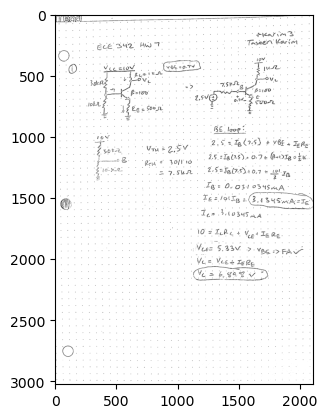

True

In [8]:
# read the image
img_path = 'image.jpg'
img = cv2.imread(img_path)


# resize and create a copy of the image
ratio = img.shape[0]/500.0
copy = img.copy()
image = imutils.resize(img, height = 500)

#gray scale the image, use gaussian blur to erase noise and apply canny edge detection filter
edges = cv2.Canny(image,75,200)
edges_u8 = edges.astype(np.uint8)

# find all image contours and take 5 largest contours.
# find the contour with four sides and mark it with circles.
cnts, hierarchy = cv2.findContours(edges_u8.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts,key=cv2.contourArea,reverse=True)[:5]

doc = None
for c in cnts:
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,0.02*peri,True)
    if len(approx) == 4:
        doc = approx
        break

if doc is not None:
    # warp the image such that there is a scanned, overhead look of the document
    warp = four_point_transform(copy, doc.reshape(4, 2) * ratio)
    warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)

    # threshold image and save image
    T = threshold_local(warp, 11, offset=10, method="gaussian")
    warp = (warp > T).astype("uint8") * 255
    # plt.imshow(imutils.resize(warp), 'gray')
    plt.imshow(warp, 'gray')
    plt.show()
else:
    print("No contour with four sides was found.")

cv2.imwrite('scanned30.jpg', warp)

<function matplotlib.pyplot.show(close=None, block=None)>

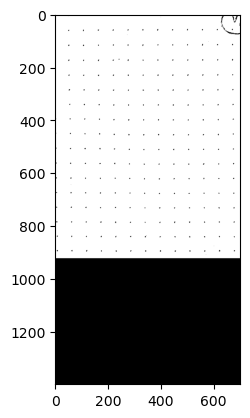

In [9]:
imaage = Image.open('./scanned29.jpg')
crop = (500, 2100, 1200, 3500)
cropped = imaage.crop(crop)
plt.imshow(cropped, 'gray')
plt.show